In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

from model_beta import ResNet, resnet50_config
from tools.train_utils import LRFinder
from tools.runner import train, evaluate, epoch_time
from tqdm import tqdm
from tools.test_utils import get_predictions, plot_confusion_matrix, plot_most_incorrect

ROOT = 'data'
data_dir = os.path.join(ROOT, 'fanpai_data_v1.0')
test_dir = os.path.join(data_dir, 'test')
classes = os.listdir(test_dir)

# 加载数据
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)
BATCH_SIZE = 64

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)



/opt/conda/envs/fanpai1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载模型
OUTPUT_DIM = len(test_data.classes)
print(test_data.classes)
model = ResNet(resnet50_config, OUTPUT_DIM)

['improper', 'proper']


In [3]:
# 测试
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)
model.load_state_dict(torch.load('/home/guohao826/fanpai_classification/tut5-model.pt'))
# # print(model.state_dict())
# test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

# print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
#       f'Test Acc @5: {test_acc_5*100:6.2f}%')

<All keys matched successfully>

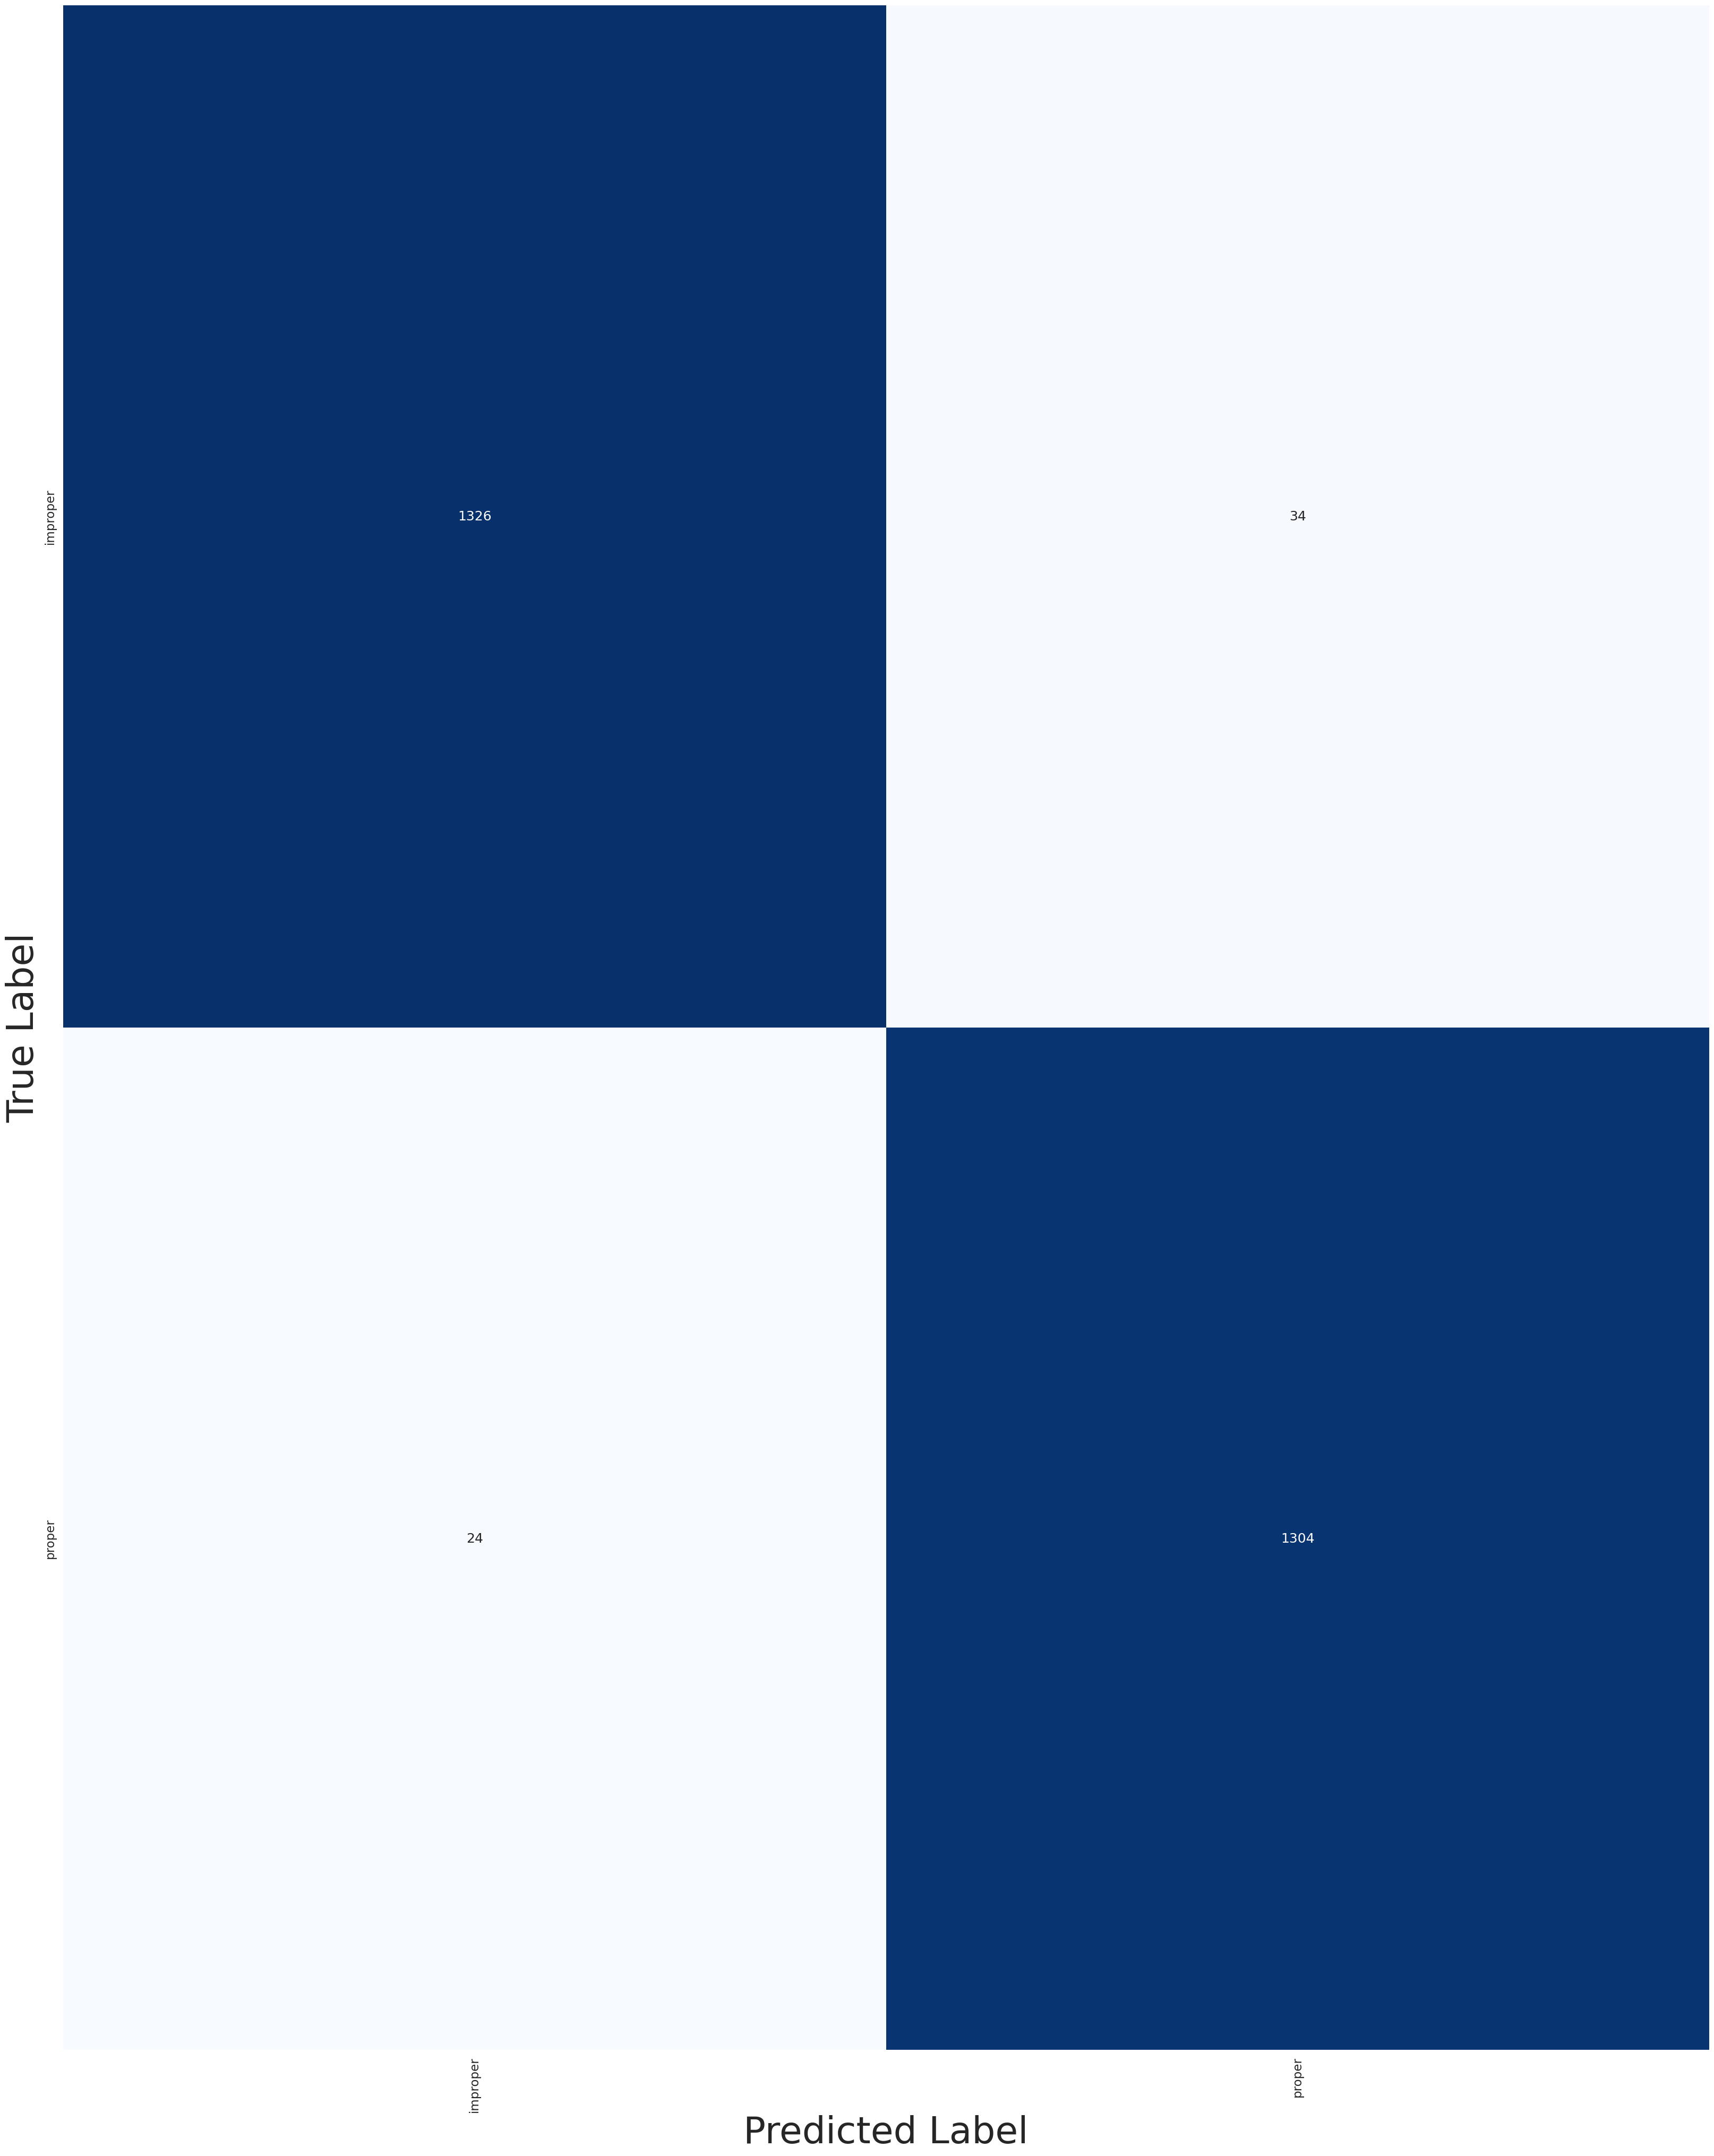

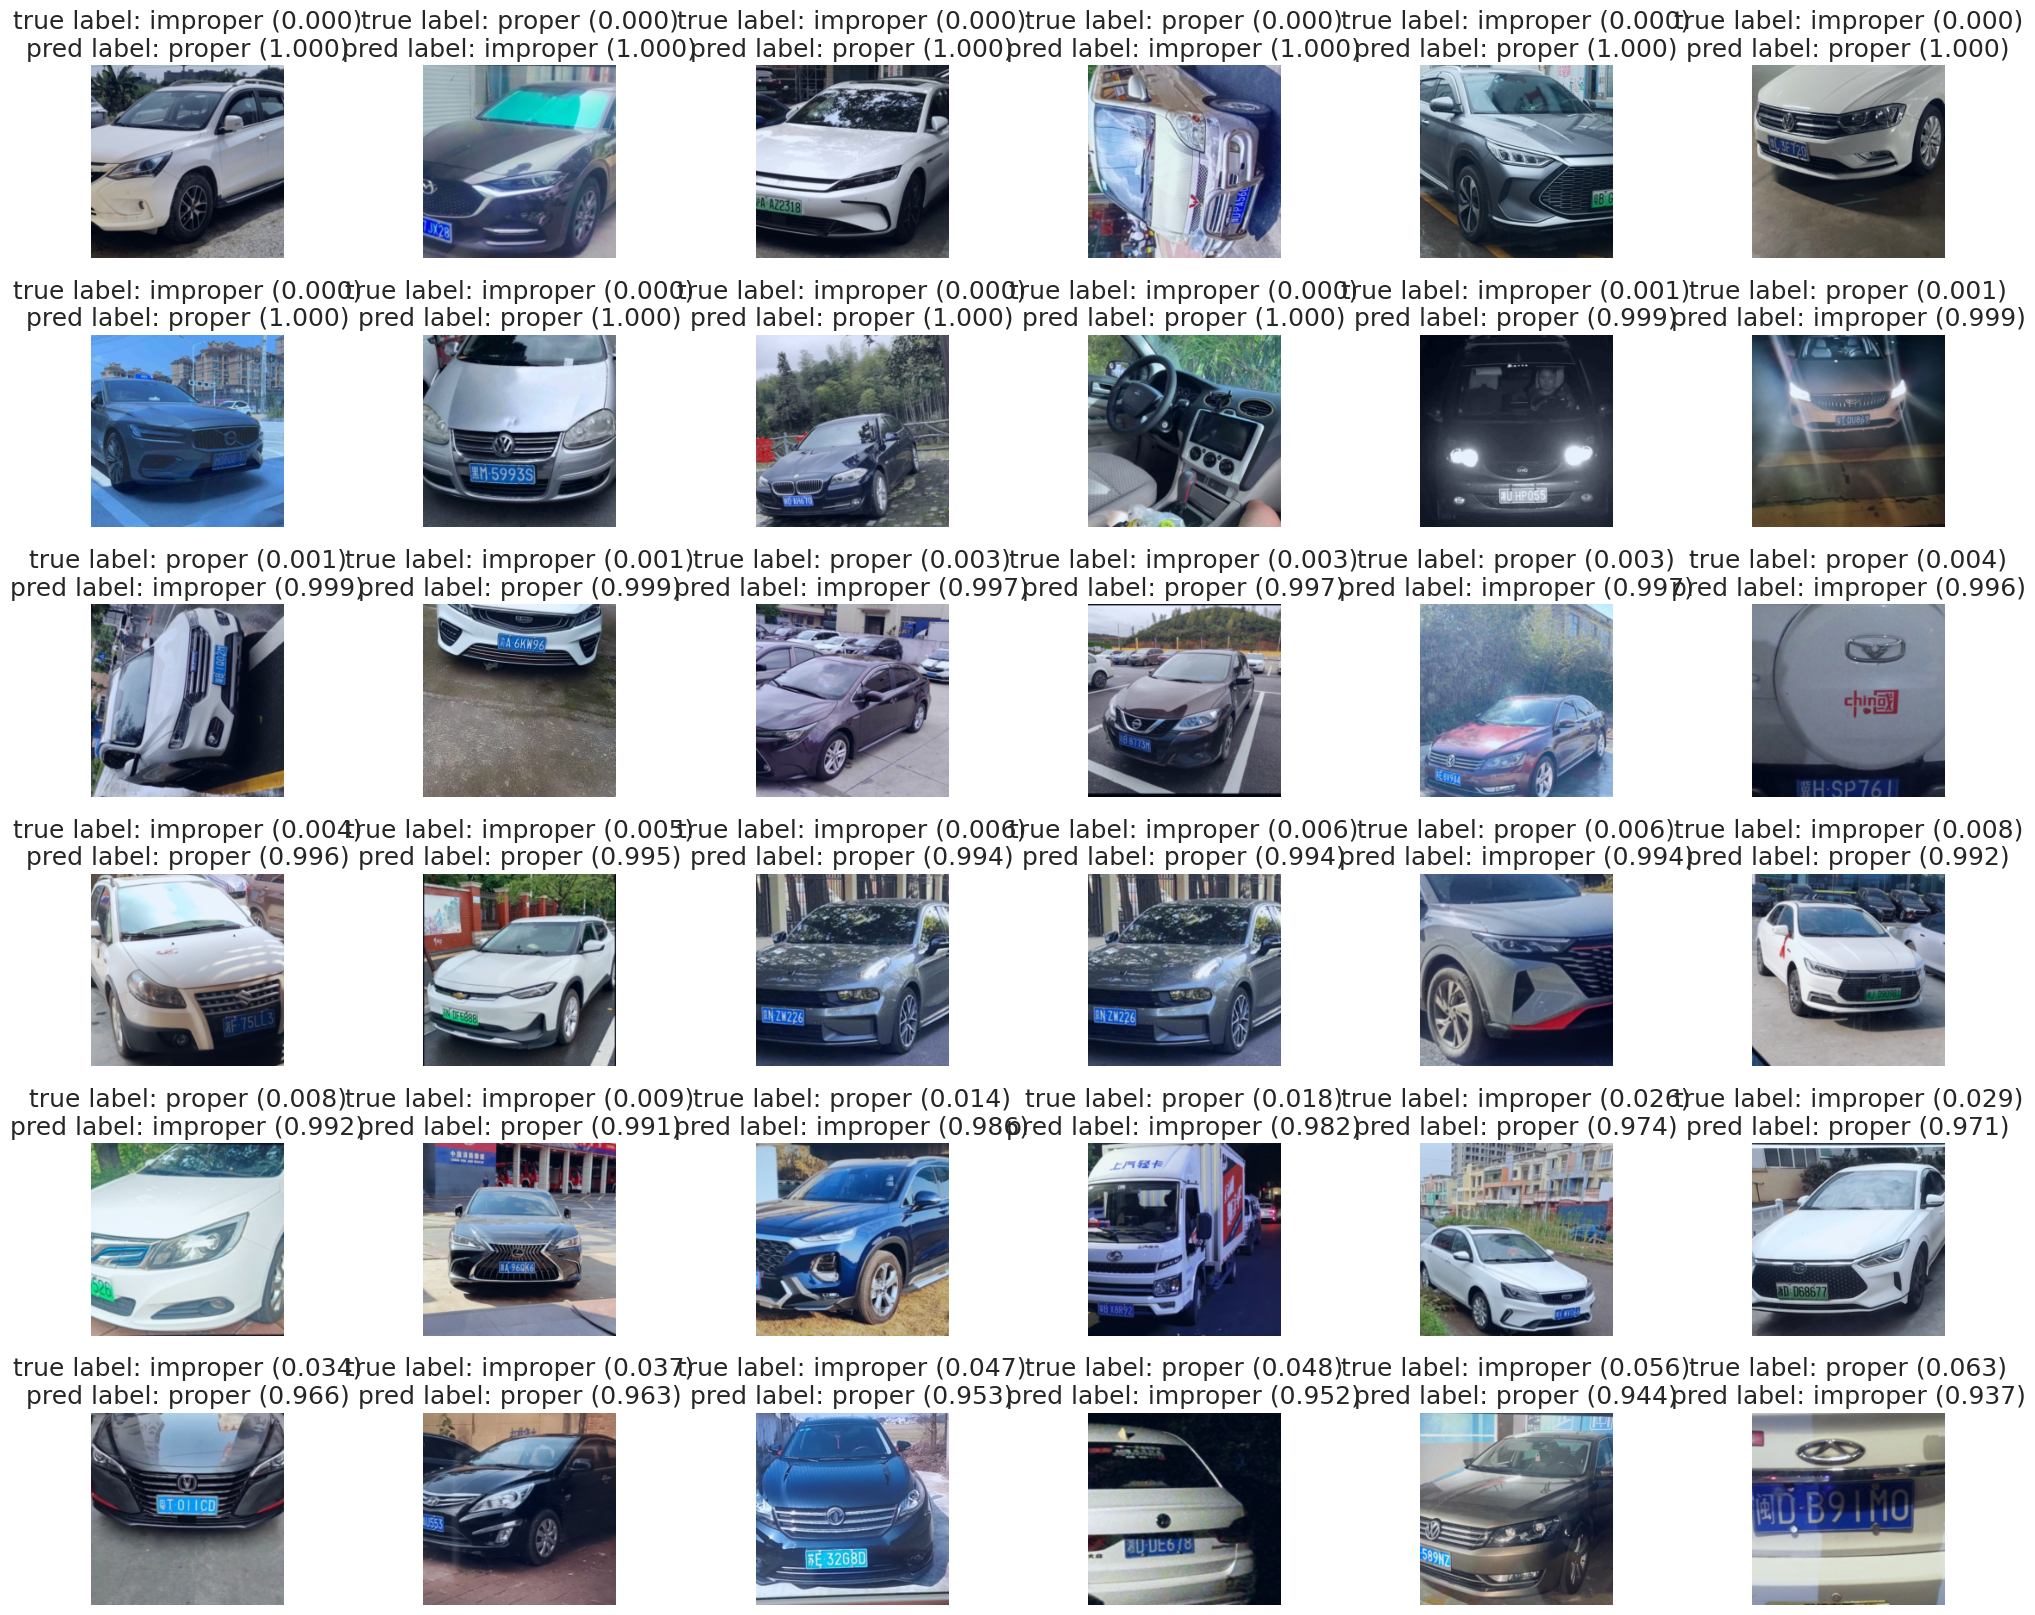

In [7]:
# 结果可视化
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels, classes)

corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)